# USW-AI-Projekt: Einfluss sozialer Medien auf Aktienkurse
## CRISP-DM Struktur
---

### 1. Business Understanding
- Ziel: Zusammenhang zwischen Twitter-Stimmung und Aktienkursentwicklung untersuchen
- Zielgruppe: Finanzanalysten, Anleger
- Fragestellung: Kann man Kursbewegungen durch Stimmung erklären oder sogar vorhersagen?

### 2. Data Understanding
- Datenquellen: Twitter API v2, yfinance
- Zeitraum: z. B. letzte 3–6 Monate
- Unternehmen: z. B. SAP, Siemens, BMW

- Daten vorbereiten & alle nötigen Libaries laden


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

%matplotlib inline
sns.set()

# To avoid Warning message inbetween ...
import warnings
warnings.filterwarnings('ignore')

### 3. Data Preparation
- Dataset laden
- Hier werden die .csv-Dateien geladen:
- Tweets.csv enthält Tweets über Tesla (z. B. Datum, Text, Sentiment)

In [4]:
import pandas as pd

company_tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Company_Tweet.csv")
tweet         = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")
company       = pd.read_csv("../Datasets/raw/tweets_top_companies/Company.csv")
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")


### 4. Merge Data
- Daten zusammenführen
- Jetzt sind für jeden Tag Kursdaten + Durchschnittssentiment in einer gemeinsamen Tabelle

In [17]:
# das sind jetzt die Daten von 2015 bis 2020, weil es davor keine Daten für Tweets gibt
# 1. Datumsspalten korrekt konvertieren
company_value['day_date'] = pd.to_datetime(company_value['day_date'])
tweet['post_date'] = pd.to_datetime(tweet['post_date'], unit='s', errors='coerce')

# 2. Tweets außerhalb gültiger Zeitspanne entfernen (NaT etc.)
tweet = tweet.dropna(subset=['post_date'])

# 3. Sentiment berechnen mit VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
tweet['sentiment_score'] = tweet['body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# 4. Durchschnittliches Sentiment pro Tag berechnen
daily_sentiment = (
    tweet
    .assign(Date = tweet['post_date'].dt.normalize())  # nur das Datum
    .groupby('Date')['sentiment_score']
    .mean()
    .reset_index()
)

# 5. Kursdaten auf Zeitraum der Tweets beschränken
start = tweet['post_date'].min()
end   = tweet['post_date'].max()

company_value = company_value[
    (company_value['day_date'] >= start) & (company_value['day_date'] <= end)
]

# 6. Merge durchführen (gemeinsames Datum)
merged_df = pd.merge(
    company_value,
    daily_sentiment,
    left_on='day_date',
    right_on='Date',
    how='inner'
)

# 7. Ergebnis anzeigen
print("Merged Shape:", merged_df.shape)
merged_df.head()

Merged Shape: (10950, 9)


,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,Date,sentiment_score
0,AAPL,2019-12-31,293.65,25247630,289.93,293.68,289.5200,2019-12-31,0.149347
1,AAPL,2019-12-30,291.52,36059610,289.46,292.69,285.2200,2019-12-30,0.139221
2,AAPL,2019-12-27,289.80,36592940,291.12,293.97,288.1200,2019-12-27,0.154059
3,AAPL,2019-12-26,289.91,23334000,284.82,289.98,284.7000,2019-12-26,0.169727
4,AAPL,2019-12-24,284.27,12119710,284.69,284.89,282.9197,2019-12-24,0.161671


### 5. Korrelation berechnen
- Korrelation zeigt, ob positive Tweets mit steigenden Kursen einhergehen (+1 = stark positiv)

In [26]:
print(merged_df[['sentiment_score', 'close_value']].isnull().sum())


sentiment_score    0
close_value        0
dtype: int64


In [15]:
correlation = merged_df[['sentiment_score', 'close_value']].corr()
print("📊 Korrelation zwischen Sentiment und Schlusskurs:")
print(correlation)

📊 Korrelation zwischen Sentiment und Schlusskurs:
                 sentiment_score  close_value
sentiment_score              NaN          NaN
close_value                  NaN          NaN


### 6.Visualisierung

Die Entwicklung des Aktienkurses von Tesla (Close-Preis)
Den durchschnittlichen Sentiment-Wert pro Tag (z. B. aus Twitter-Daten)

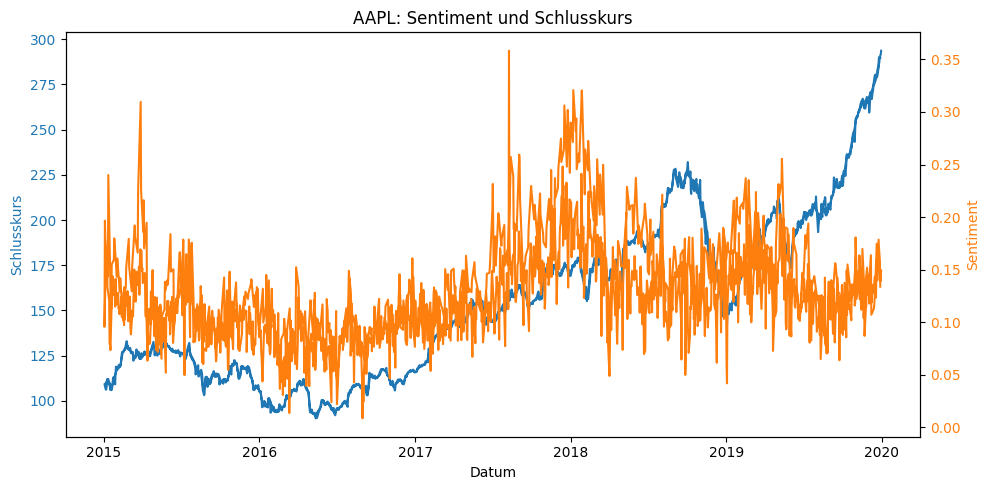

In [2]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funktion: Sentiment + Kursdaten mergen
def merge_sentiment_and_stock_data(company_df, tweet_df):
    """
    Führt Kursdaten und Twitter-Sentimentdaten für alle Ticker-Symbole zusammen.

    Args:
        company_df (pd.DataFrame): Kursdaten mit Spalten 'ticker_symbol', 'day_date', ...
        tweet_df (pd.DataFrame): Tweets mit Spalten 'ticker_symbol', 'post_date', 'body'

    Returns:
        dict: Key = Ticker (z. B. 'AAPL'), Value = gemergter DataFrame (Kurs + Sentiment)
    """

    # Datumsformate vereinheitlichen
    company_df['day_date'] = pd.to_datetime(company_df['day_date'])
    tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s', errors='coerce')
    tweet_df = tweet_df.dropna(subset=['post_date'])

    # Prüfen ob 'ticker_symbol' vorhanden ist
    if 'ticker_symbol' not in tweet_df.columns:
        raise ValueError(f"'ticker_symbol' fehlt in tweet_df. Vorhandene Spalten: {tweet_df.columns.tolist()}")

    # Sentiment berechnen
    analyzer = SentimentIntensityAnalyzer()
    tweet_df['sentiment_score'] = tweet_df['body'].apply(
        lambda x: analyzer.polarity_scores(str(x))['compound']
    )

    result = {}

    for ticker in company_df['ticker_symbol'].unique():
        comp = company_df[company_df['ticker_symbol'] == ticker].copy()
        tw = tweet_df[tweet_df['ticker_symbol'] == ticker].copy()

        if tw.empty or comp.empty:
            continue

        # Ø-Sentiment pro Tag berechnen
        tw['Date'] = tw['post_date'].dt.normalize()
        daily_sentiment = tw.groupby('Date')['sentiment_score'].mean().reset_index()

        # Kursdaten auf Zeitraum der Tweets beschränken
        start, end = tw['post_date'].min(), tw['post_date'].max()
        comp = comp[(comp['day_date'] >= start) & (comp['day_date'] <= end)]

        # Merge durchführen
        merged = pd.merge(
            comp,
            daily_sentiment,
            left_on='day_date',
            right_on='Date',
            how='inner'
        )

        result[ticker] = merged

    return result

# Funktion: Visualisierung
def plot_sentiment_vs_stock(df, ticker):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_title(f"{ticker}: Sentiment und Schlusskurs")
    ax1.set_xlabel("Datum")
    ax1.set_ylabel("Schlusskurs", color="tab:blue")
    ax1.plot(df['day_date'], df['close_value'], color="tab:blue", label="Close Value")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment", color="tab:orange")
    ax2.plot(df['day_date'], df['sentiment_score'], color="tab:orange", label="Sentiment")
    ax2.tick_params(axis='y', labelcolor="tab:orange")

    fig.tight_layout()
    plt.show()

# CSV-Dateien laden
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")
tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")

# Hinweis: Hier ist der Fehler entstanden. tweet_df braucht eine Spalte 'ticker_symbol'.
# Wenn diese fehlt, musst du sie ggf. aus einer anderen Spalte erzeugen oder zu Testzwecken setzen:
# Beispiel (wenn du nur einen Ticker testest wie 'AAPL'):
tweet['ticker_symbol'] = 'AAPL'  # Entferne oder ersetze dies später durch korrekte Daten

# Merge durchführen
merged_data = merge_sentiment_and_stock_data(company_value, tweet)

# Beispielplot für AAPL
plot_sentiment_vs_stock(merged_data['AAPL'], 'AAPL')


In [12]:
company_df = pd.read_csv("../Datasets/raw/company_values/Company.csv")
tweet_df = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")


In [15]:
def extract_ticker_from_text(text, company_map):
    for name, ticker in company_map.items():
        if pd.notna(text) and name.lower() in text.lower():
            return ticker
    return None

company_map = dict(zip(company_df['company_name'], company_df['ticker_symbol']))
tweet_df['ticker_symbol'] = tweet_df['body'].apply(lambda x: extract_ticker_from_text(x, company_map))


R2-Score: 0.18701816469555255
MSE: 1453.9970398011599


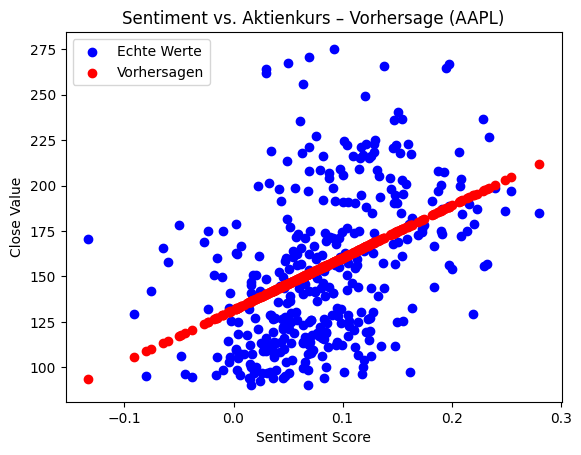

In [17]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 1. CSV-Dateien laden
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")
tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")

# 2. Merge-Funktion
def merge_sentiment_and_stock_data(company_df, tweet_df):
    company_df['day_date'] = pd.to_datetime(company_df['day_date'])
    tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s', errors='coerce')
    tweet_df = tweet_df.dropna(subset=['post_date'])

    if 'ticker_symbol' not in tweet_df.columns:
        raise ValueError(f"'ticker_symbol' fehlt in tweet_df. Vorhandene Spalten: {tweet_df.columns.tolist()}")

    analyzer = SentimentIntensityAnalyzer()
    tweet_df['sentiment_score'] = tweet_df['body'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

    result = {}
    for ticker in company_df['ticker_symbol'].unique():
        comp = company_df[company_df['ticker_symbol'] == ticker].copy()
        tw = tweet_df[tweet_df['ticker_symbol'] == ticker].copy()

        if tw.empty or comp.empty:
            continue

        tw['Date'] = tw['post_date'].dt.normalize()
        daily_sentiment = tw.groupby('Date')['sentiment_score'].mean().reset_index()

        start, end = tw['post_date'].min(), tw['post_date'].max()
        comp = comp[(comp['day_date'] >= start) & (comp['day_date'] <= end)]

        merged = pd.merge(
            comp,
            daily_sentiment,
            left_on='day_date',
            right_on='Date',
            how='inner'
        )

        result[ticker] = merged

    return result

# 3. Merge durchführen
merged_data = merge_sentiment_and_stock_data(company_value, tweet_df)

# 4. Modelltraining für Beispiel AAPL
df = merged_data['AAPL']
X = df[['sentiment_score']]
y = df['close_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R2-Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# 5. Visualisierung
plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
plt.xlabel("Sentiment Score")
plt.ylabel("Close Value")
plt.legend()
plt.title("Sentiment vs. Aktienkurs – Vorhersage (AAPL)")
plt.show()

In [18]:
print(merged_data.keys())

dict_keys(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'])


In [22]:
def run_regression(ticker, merged_data):
    if ticker not in merged_data:
        print(f"{ticker} nicht vorhanden.")
        return

    df = merged_data[ticker]
    X = df[['sentiment_score']]
    y = df['close_value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Ticker: {ticker}")
    print("R2-Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
    plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.legend()
    plt.title(f"Sentiment vs. Aktienkurs – Vorhersage ({ticker})")
    plt.show()


Ticker: GOOGL
R2-Score: 0.005640746572649236
MSE: 57323.24370312773


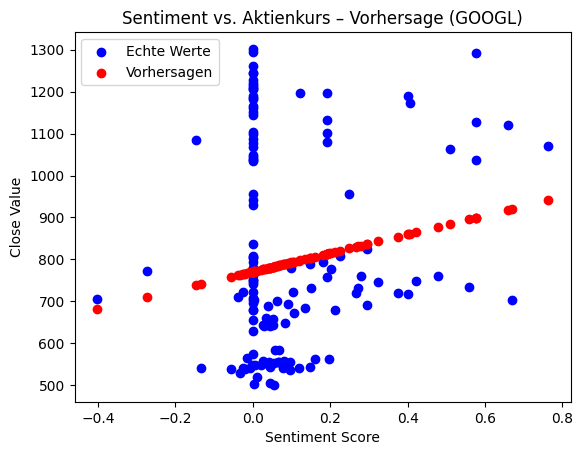

In [23]:
run_regression("GOOGL", merged_data)

Ticker: AAPL
R2-Score: 0.18701816469555255
MSE: 1453.9970398011599


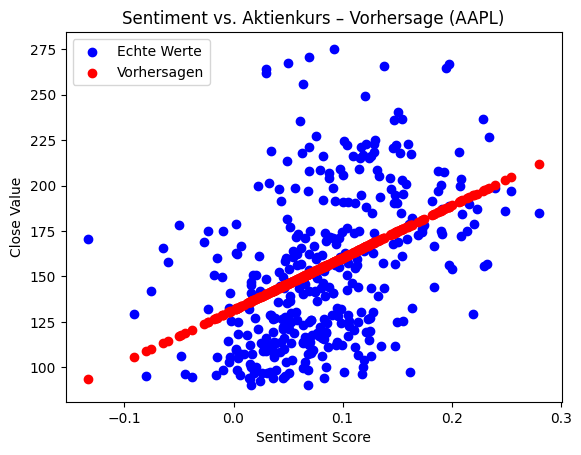

Ticker: AMZN
R2-Score: 0.04861782450331542
MSE: 263594.04602270306


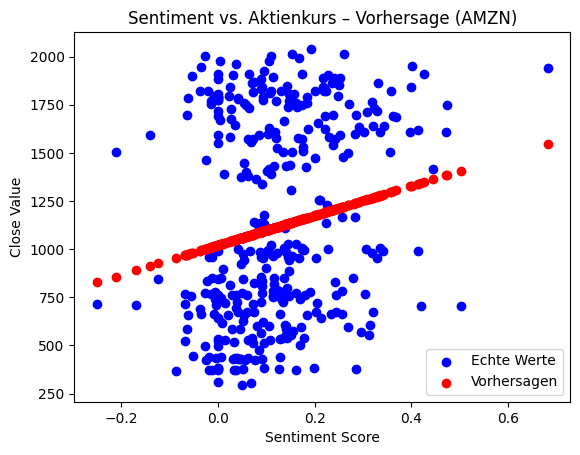

Ticker: GOOGL
R2-Score: 0.005640746572649236
MSE: 57323.24370312773


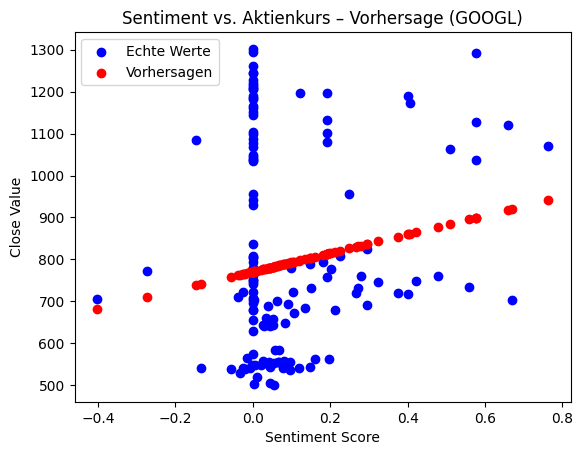

Ticker: MSFT
R2-Score: 0.10971281282060108
MSE: 874.8431361386508


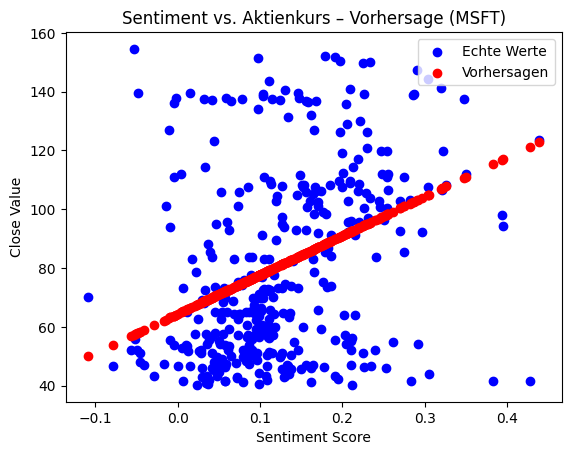

Ticker: TSLA
R2-Score: 0.0020126331096451677
MSE: 2266.448077784644


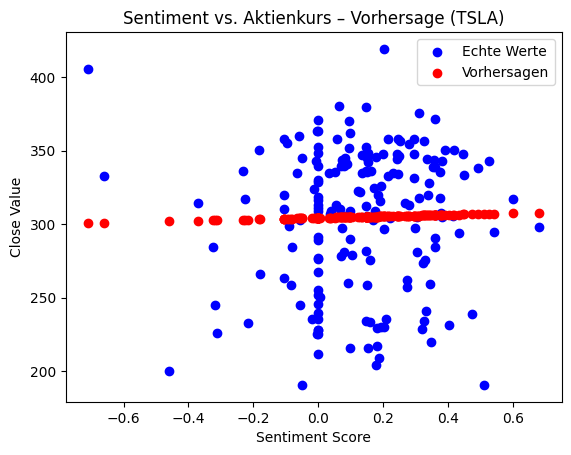

In [24]:
for ticker in merged_data:
    run_regression(ticker, merged_data)

In [ ]:
## Auswertung der Regressionsergebnisse

| Ticker | R²-Score | MSE | Interpretation |
|--------|----------|-----|----------------|
| AAPL   | 0.19     | 1454 | leichter Zusammenhang |
| AMZN   | 0.05     | 263594 | kaum Zusammenhang |
| GOOGL  | 0.01     | 57323 | kein signifikanter Zusammenhang |
| MSFT   | 0.11     | 875 | schwacher Zusammenhang |
| TSLA   | 0.00     | 2266 | praktisch kein Zusammenhang |

**Fazit:** AAPL zeigt die stärkste lineare Beziehung zwischen Sentiment und Aktienkurs, während TSLA und GOOGL kaum vorhersagbare Zusammenhänge aufweisen.


In [ ]:
##Statt linearer Regression testen wir ein nicht-lineares Modell: RandomForestRegressor, das auch komplexe Beziehungen erkennt.

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
def run_random_forest(ticker, merged_data):
    if ticker not in merged_data:
        print(f"{ticker} nicht vorhanden.")
        return

    df = merged_data[ticker]
    X = df[['sentiment_score']]
    y = df['close_value']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Ticker: {ticker}")
    print("R2-Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    plt.scatter(X_test, y_test, color='blue', label='Echte Werte')
    plt.scatter(X_test, y_pred, color='red', label='Vorhersagen')
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.legend()
    plt.title(f"Random Forest: Sentiment vs. Kurs ({ticker})")
    plt.show()


Ticker: AAPL
R2-Score: -0.2662103115713459
MSE: 2264.584477586752


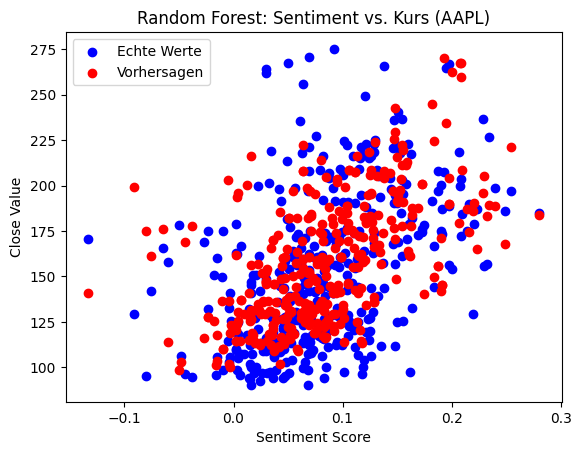

Ticker: AMZN
R2-Score: -0.3485467136005762
MSE: 373634.1647382839


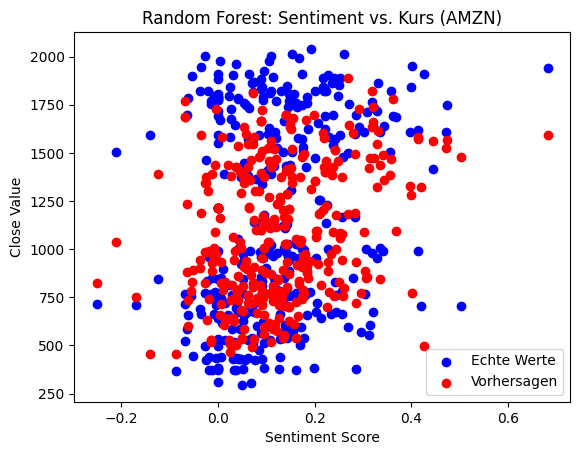

Ticker: GOOGL
R2-Score: 0.4359822870692056
MSE: 32514.732175291047


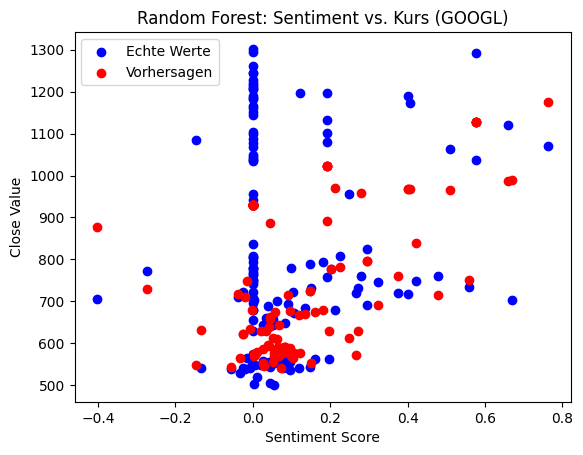

Ticker: MSFT
R2-Score: -0.1559849815442309
MSE: 1135.9317994762407


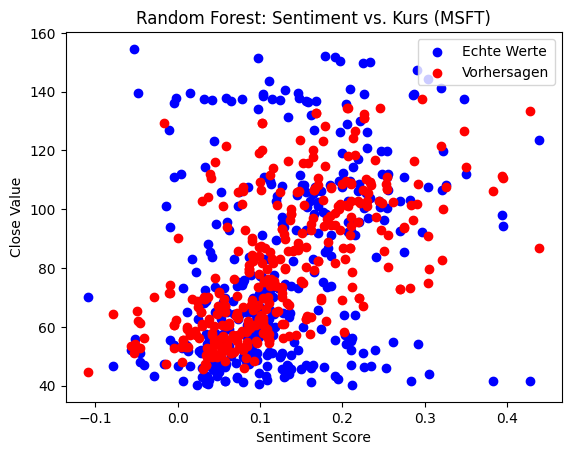

Ticker: TSLA
R2-Score: -0.3623290258636145
MSE: 3093.874836912684


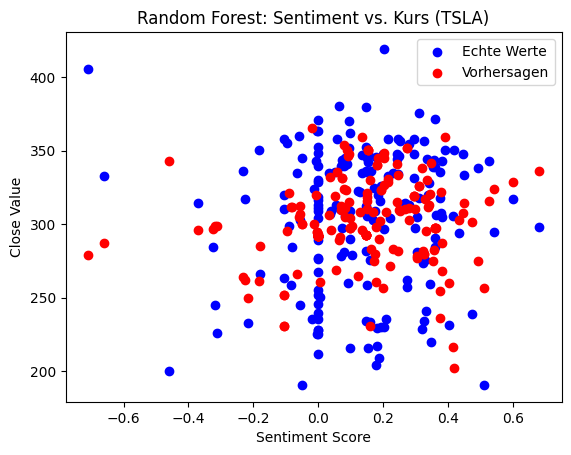

In [49]:
for ticker in merged_data:
    print("=" * 50)
    run_random_forest(ticker, merged_data)


In [ ]:
##Ergebnisse vergleichen: Sentiment und Kurswerte für verschiedene Unternehmen

In [57]:
tweet_df['sentiment_score'] = tweet_df['body'].apply(…)


SyntaxError: invalid character '…' (U+2026) (3351157963.py, line 1)

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Liste aller Firmen im Datensatz
firmen = merged_df['ticker_symbol'].unique()

# Für jede Firma den Zusammenhang darstellen
for firma in firmen:
    df_firma = merged_df[merged_df['ticker_symbol'] == firma]

    if df_firma.shape[0] < 30:
        continue  # zu wenige Daten, überspringen

    plt.figure(figsize=(10, 5))
    sns.regplot(data=df_firma, x='sentiment_score', y='close_value', scatter_kws={'alpha':0.3})
    plt.title(f"{firma}: Sentiment vs. Close Value")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Close Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


KeyError: 'sentiment_score'

<Figure size 1000x500 with 0 Axes>

📌 Zeigt die Verteilung der Sentiment-Scores (z. B. wie viele Tweets sind stark negativ, positiv oder neutral).

In [ ]:
column_distplot(tweet_df, column_name="afinn_score", bins=10)
column_distplot(tweet_df, column_name="vander_score", bins=10)


🔹 2. Liniendiagramm: Sentiment vs. Aktienkurs über Zeit

📌 Visualisiert zeitlich: Wann starke positive oder negative Tweets auftraten und wie sich der Aktienkurs parallel dazu veränderte.



In [ ]:
def sentiment_overtime(tweet_df, stock_df, title, score_column_name="score"):
    fig = plt.figure(figsize=(24,10))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()

    # Sentiment (Vader oder Afinn)
    ax1.vlines(tweet_df['day_date'], 0, tweet_df[score_column_name])
    ax1.axhline(y=0, color='r', linestyle='-')

    # Aktienkurs (Close)
    ax2.plot(stock_df['day_date'], stock_df['close_value'], color='orange', label='Stock price')

    ax2.set_title("Effects of " + title +" tweets to stock price")
    ax1.set_xlabel('Datum')
    ax1.set_ylabel('Sentiment Score', color="blue")
    plt.show()
